# Density Functional Theory python examples


I'll add more info soon, for now here it is, shortly:

This follows the assignments for lectures of Thomas Arias, lectures available on youtube. You'll find info and an embedded video of the first lecture in the DFT Quantum Dot page on the Computational Physics Blog: https://compphys.go.ro/dft-for-a-quantum-dot/

The following links are available on the page mentioned above, but I'll repeat them here:

Assignments are described here: https://drive.google.com/drive/folders/0B8lnMKudhQYMd2NWTkV1akpYSTQ?hl=en

A paper that describes the formalism: https://arxiv.org/abs/cond-mat/9909130

For now this is work in progress, I'll add more to it (including comments), hopefully it will cover at least as much as the https://github.com/aromanro/DFTQuantumDot project.

### The Poisson Equation

This corresponds to the first assigment and it covers what the https://github.com/aromanro/Poisson project covers (described here: https://compphys.go.ro/solving-poisson-equation/).

In [1]:
import math as m
import numpy as np
import scipy as sp
import scipy.linalg as splalg
import matplotlib.pyplot as plt
%matplotlib inline
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #disable gpu usage for now, I have a bug

In [2]:
S = np.array([32, 32, 32])
ms = np.arange(np.prod(S))
m1 = np.remainder(ms, S[0])
m2 = np.remainder(np.floor_divide(ms, S[0]), S[1])
m3 = np.remainder(np.floor_divide(ms, S[0] * S[1]), S[2])
M = np.asarray([m1, m2, m3]).transpose()

In [3]:
n1 = np.array([x - (x > S[0]/2) * S[0] for x in m1])
n2 = np.array([x - (x > S[1]/2) * S[1] for x in m2])
n3 = np.array([x - (x > S[2]/2) * S[2] for x in m3])
N = np.asarray([n1, n2, n3]).transpose()

In [4]:
R=np.diag([6, 6, 6])

In [5]:
r = M @ np.linalg.inv(np.diag(S)) @ np.transpose(R)
G = 2 * m.pi * N @ np.linalg.inv(R)
G2 = np.sum(G * G, axis=1)
G2 = np.reshape(G2, (G2.size, 1))

In [6]:
cellCenter = np.sum(R, axis = 1) / 2

In [7]:
vecsFromCenter = r - np.ones((np.prod(S), 1)) * cellCenter
dr = np.sqrt(np.sum(vecsFromCenter * vecsFromCenter, 1))

In [8]:
def Gaussian(r, sigma = 0.5):
    twosigma2 = 2. * sigma * sigma
    return np.exp(-r*r/twosigma2) / np.power(np.sqrt(m.pi * twosigma2), 3);    

In [9]:
sigma1 = 0.75
sigma2 = 0.5
g1 = Gaussian(dr, sigma1)
g2 = Gaussian(dr, sigma2)
n = g2 - g1
n = np.reshape(n, (n.size, 1))

In [10]:
print ("Normalization check on g1: ", np.sum(g1) * np.linalg.det(R) / np.prod(S))

Normalization check on g1:  0.99979348165842


In [11]:
print ("Normalization check on g2: ", np.sum(g2) * np.linalg.det(R) / np.prod(S))

Normalization check on g2:  0.9999999916978626


In [12]:
print ("Total charge check: ", np.sum(n) * np.linalg.det(R) / np.prod(S))

Total charge check:  0.00020651003944279004


In [13]:
def fft3(dat, N, s):
    if s == 1:
        result = np.reshape(np.fft.ifftn(np.reshape(dat, (N[0], N[1], N[2]), order='F')) * np.prod(N), dat.shape, order='F')        
    else:
        result = np.reshape(np.fft.fftn(np.reshape(dat, (N[0], N[1], N[2]), order='F')), dat.shape, order='F')
    
    return result

In [14]:
def cI(input):
    return fft3(input, S, 1)

In [15]:
def cJ(input):
    return 1. / np.prod(S) * fft3(input, S, -1)

In [16]:
def O(input):
    return np.linalg.det(R) * input

In [17]:
def L(input):    
    return -np.linalg.det(R) * G2 * input

In [18]:
def Linv(inp):
    if inp.ndim == 1:
        input = np.reshape(inp, (inp.size, 1))
    else:
        input = inp
        
    old_settings = np.seterr(divide='ignore', invalid='ignore')
    result = -1. / np.linalg.det(R) * input / np.reshape(G2, input.shape)
    result[0] = 0
    np.seterr(**old_settings)
    return result    

In [19]:
def Poisson(inp):
    if inp.ndim == 1:
        n = np.reshape(inp, (inp.size, 1))
    else:
        n = inp
        
    return cI(Linv(-4. * m.pi * O(cJ(n))))

In [20]:
phi = Poisson(n)

In [21]:
Unum = 0.5 * np.real(cJ(phi).transpose().conjugate() @ O(cJ(n)))
Uanal=((1./sigma1+1./sigma2)/2.- np.sqrt(2.) / np.sqrt(sigma1*sigma1 + sigma2*sigma2))/np.sqrt(m.pi)
print('Numeric, analytic Coulomb energy:', Unum[0,0], Uanal)

Numeric, analytic Coulomb energy: 0.05514065651927543 0.05514252769473334


In [22]:
def Plot(dat):

    if dat.ndim != 3:
        dat = np.reshape(dat, S, order='F')
    
    fig=plt.figure(figsize=(25, 15))

    x = np.arange(0, S[1])
    y = np.arange(0, S[2])
    xs, ys = np.meshgrid(x, y, indexing='ij')

    toplot1 = dat[int(S[0]/2),:,:]
        
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_surface(xs, ys, toplot1, cmap='viridis', edgecolor='none')

    x = np.arange(0, S[0])
    xs, ys = np.meshgrid(x, y, indexing='ij')

    toplot2 = dat[:,int(S[1]/2),:]
    
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_surface(xs, ys, toplot2, cmap='viridis', edgecolor='none')

    y = np.arange(0, S[1])
    xs, ys = np.meshgrid(x, y, indexing='ij')
    toplot3 = dat[:,:,int(S[2]/2)]
    
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_surface(xs, ys, toplot3, cmap='viridis', edgecolor='none')

    plt.tight_layout
    plt.show()

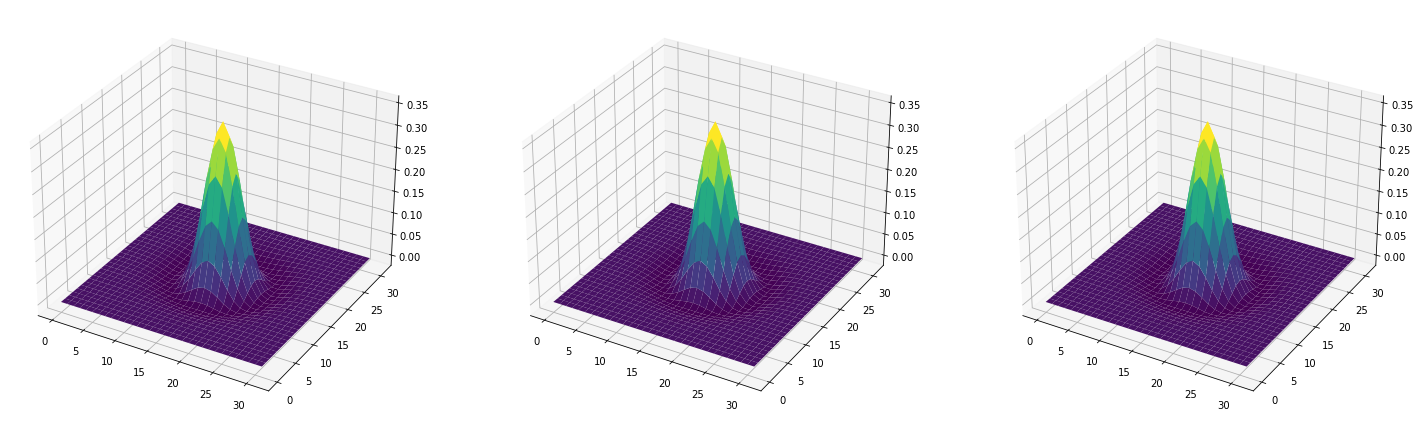

In [23]:
Plot(n)

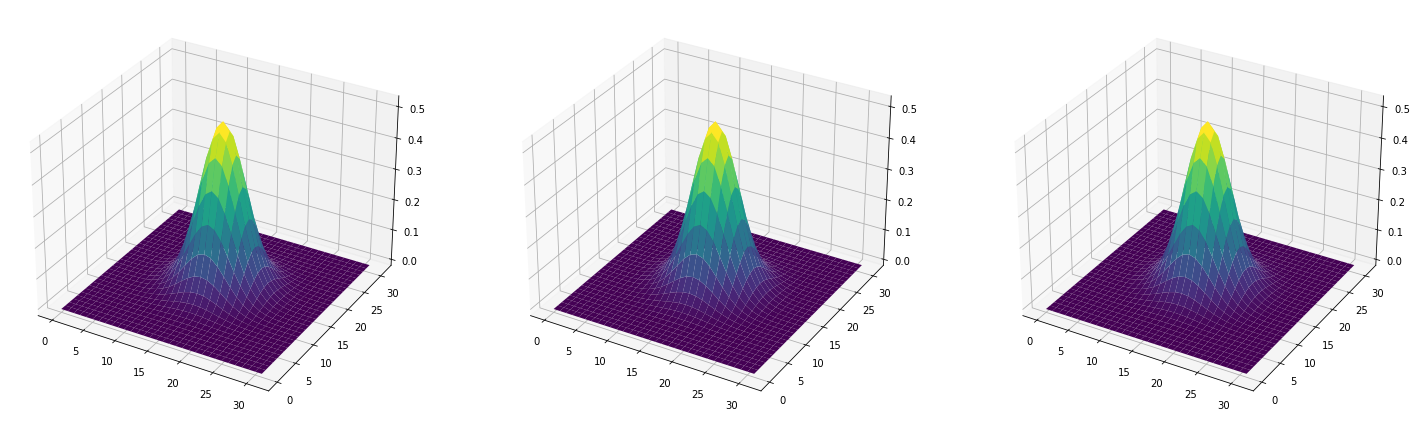

In [24]:
Plot(np.real(phi))

In [25]:
X = np.asarray([[0, 0, 0], [1.75, 0, 0]])
Sf = np.sum(np.exp(-1j * G @ X.transpose()), axis = 1)
Z = 1

In [26]:
sigma1 = 0.25
g1 = Z * Gaussian(dr, sigma1)

In [27]:
n = cI(cJ(g1)* Sf)
n = np.real(n)

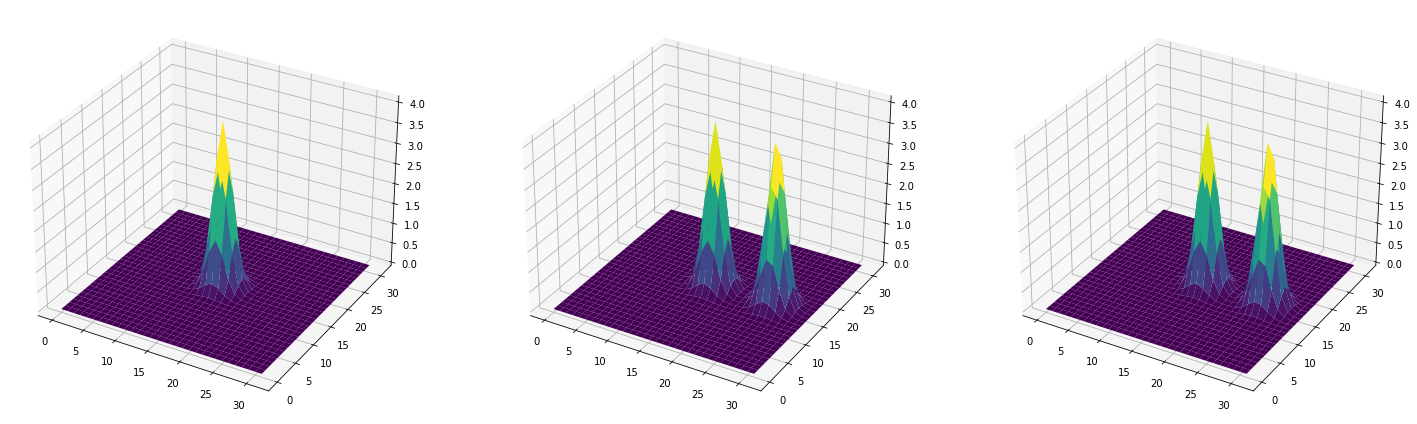

In [28]:
Plot(n)

In [29]:
Uself = Z*Z/(2.*m.sqrt(m.pi))*(1./sigma1)*np.size(X,0)

In [30]:
phi = Poisson(n)

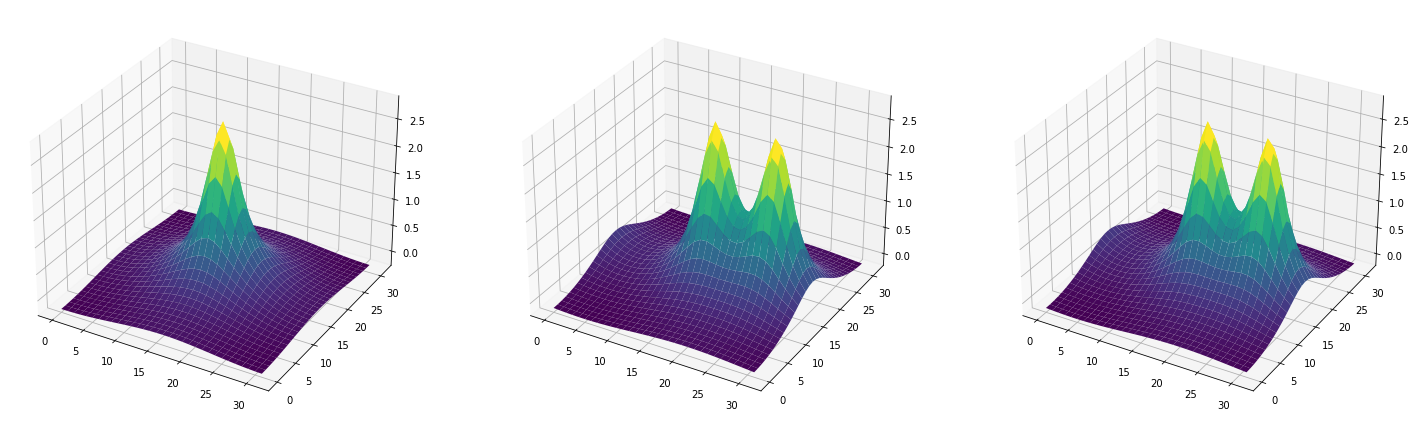

In [31]:
Plot(np.real(phi))

In [32]:
Unum = 0.5 * np.real(cJ(phi).transpose().conjugate() @ O(cJ(n)))
print('Ewald energy:', Unum - Uself)
print('Unum:', Unum)
print('Uself:', Uself)

Ewald energy: [-0.33353347]
Unum: [1.92322487]
Uself: 2.256758334191025


### Assignment 2: Implement variational solution to Schrodinger's equation and Kohn-Sham equations using steepest descents

First, let's repeat initialization similarly as above but with different params:

In [33]:
S = np.array([20, 25, 30])
ms = np.arange(np.prod(S))
m1 = np.remainder(ms, S[0])
m2 = np.remainder(np.floor_divide(ms, S[0]), S[1])
m3 = np.remainder(np.floor_divide(ms, S[0] * S[1]), S[2])
M = np.asarray([m1, m2, m3]).transpose()

n1 = np.array([x - (x > S[0]/2) * S[0] for x in m1])
n2 = np.array([x - (x > S[1]/2) * S[1] for x in m2])
n3 = np.array([x - (x > S[2]/2) * S[2] for x in m3])
N = np.asarray([n1, n2, n3]).transpose()

r = M @ np.linalg.inv(np.diag(S)) @ np.transpose(R)
G = 2. * m.pi * N @ np.linalg.inv(R)
G2 = np.sum(G * G, axis=1)
G2 = np.reshape(G2, (G2.size, 1))

vecsFromCenter = r - np.ones((np.prod(S), 1)) * cellCenter
dr2 = np.sum(vecsFromCenter * vecsFromCenter, 1)
dr = np.sqrt(dr2)

In [34]:
def cI(inp):
    if inp.ndim == 1:
        input = np.reshape(inp, (inp.size, 1))
    else:
        input = inp
        
    out = np.zeros(input.shape, dtype = "complex_")    
    for col in range(np.size(input, 1)):
        out[:,col] = fft3(input[:,col], S, 1)
    
    return out

In [35]:
def cJ(inp):
    if inp.ndim == 1:
        input = np.reshape(inp, (inp.size, 1))
    else:
        input = inp
    
    norm = 1. / np.prod(S)
    out = np.zeros(input.shape, dtype = "complex_")
    
    for col in range(np.size(input, 1)):
        out[:,col] = norm * fft3(input[:,col], S, -1)
    
    return out

In [36]:
def L(inp):
    if inp.ndim == 1:
        input = np.reshape(inp, (inp.size, 1))
    else:
        input = inp
    
    return -np.linalg.det(R) * (G2 @ np.ones((1, np.size(input, 1)))) * input

In [37]:
def cIdag(inp):
    if inp.ndim == 1:
        input = np.reshape(inp, (inp.size, 1))
    else:
        input = inp

    out = np.zeros(input.shape, dtype = "complex_")

    for col in range(np.size(input, 1)):
        out[:,col] = fft3(input[:,col], S, -1)
    
    return out

In [38]:
def cJdag(inp):
    if inp.ndim == 1:
        input = np.reshape(inp, (inp.size, 1))
    else:
        input = inp
    
    norm = 1. / np.prod(S)
    out = np.zeros(input.shape, dtype = "complex_")
    
    for col in range(np.size(input, 1)):
        out[:,col] = norm * fft3(input[:,col], S, 1)
    
    return out

Test on what we computed already

In [39]:
sigma1 = 0.75
sigma2 = 0.5
g1 = Gaussian(dr, sigma1)
g2 = Gaussian(dr, sigma2)
n = g2 - g1
n = np.reshape(n, (n.size, 1))

print ("Normalization check on g1: ", np.sum(g1) * np.linalg.det(R) / np.prod(S))
print ("Normalization check on g2: ", np.sum(g2) * np.linalg.det(R) / np.prod(S))
print ("Total charge check: ", np.sum(n) * np.linalg.det(R) / np.prod(S))

phi = Poisson(n)

Unum = 0.5 * np.real(cJ(phi).transpose().conjugate() @ O(cJ(n)))
Uanal=((1./sigma1+1./sigma2)/2.- np.sqrt(2.) / np.sqrt(sigma1*sigma1 + sigma2*sigma2))/np.sqrt(m.pi)
print('Numeric, analytic Coulomb energy:', Unum[0, 0], Uanal)

Normalization check on g1:  0.9997810064268026
Normalization check on g2:  0.9999999900968858
Total charge check:  0.00021898367008302207
Numeric, analytic Coulomb energy: 0.055140543755668917 0.05514252769473334


Let's solve the Schrodinger equation

In [40]:
V = 2. * dr2
V = np.reshape(V, (V.size, 1))

In [41]:
Vdual=cJdag(O(cJ(V)))

In [42]:
def diagouter(A, B):
    return np.sum(A*B.conjugate(),axis=1)

In [43]:
def getE(W):
    U = W.transpose().conjugate() @ O(W)
    Uinv = np.linalg.inv(U)
    IW = cI(W)
    n = diagouter(IW @ Uinv, IW)
    E = np.real(-0.5 * np.sum(diagouter(L(W @ Uinv), W)) + Vdual.transpose().conjugate() @ n)
    return E

In [44]:
def Diagprod(a, B):
    return (a @ np.ones((1, np.size(B, axis = 1)))) * B

In [45]:
def H(W):
    return -0.5 * L(W) + cIdag(Diagprod(Vdual, cI(W)))

In [46]:
def getgrad(W):
    U = W.transpose().conjugate() @ O(W)
    Uinv = np.linalg.inv(U)
    HW = H(W)  
    return (HW - (O(W) @ Uinv) @ (W.transpose().conjugate() @ HW)) @ Uinv

In [47]:
def orthogonalize(W):
    U = W.transpose().conjugate() @ O(W)
    return W @ np.linalg.inv(splalg.sqrtm(U))

In [48]:
def sd(W, Nit):
    alfa = 0.00003
    
    for i in range(Nit):
        W = W - alfa * getgrad(W)
    
    return W

In [49]:
def getPsi(W):
    Y = orthogonalize(W)
    mu = Y.transpose().conjugate() @ H(Y)
    
    epsilon, D = np.linalg.eig(mu)
    epsilon = np.real(epsilon)
    
    idx = epsilon.argsort()[::]   
    epsilon = epsilon[idx]
    D = D[:,idx]
    
    Psi = Y @ D
    
    return Psi, epsilon

In [50]:
X = np.asarray([[0, 0, 0], [4, 0, 0]])
Sf = np.sum(np.exp(-1j * G @ X.transpose()), axis = 1)

Z = 1
sigma1 = 0.25

g1 = Z * Gaussian(dr, sigma1)
g1 = np.reshape(g1, (g1.size, 1))
n = cI(cJ(g1) * Sf)
n = np.real(n)

In [51]:
Ns = 4
np.random.seed(100)

W = np.random.randn(np.prod(S),Ns) + 1j * np.random.randn(np.prod(S),Ns)
W = orthogonalize(W)

In [52]:
W = sd(W,600)

In [53]:
Psi, epsilon = getPsi(W)

In [54]:
epsilon

array([2.99999958, 5.00006754, 5.00019448, 5.0024204 ])

State no: 0 energy value: 2.9999995788292972


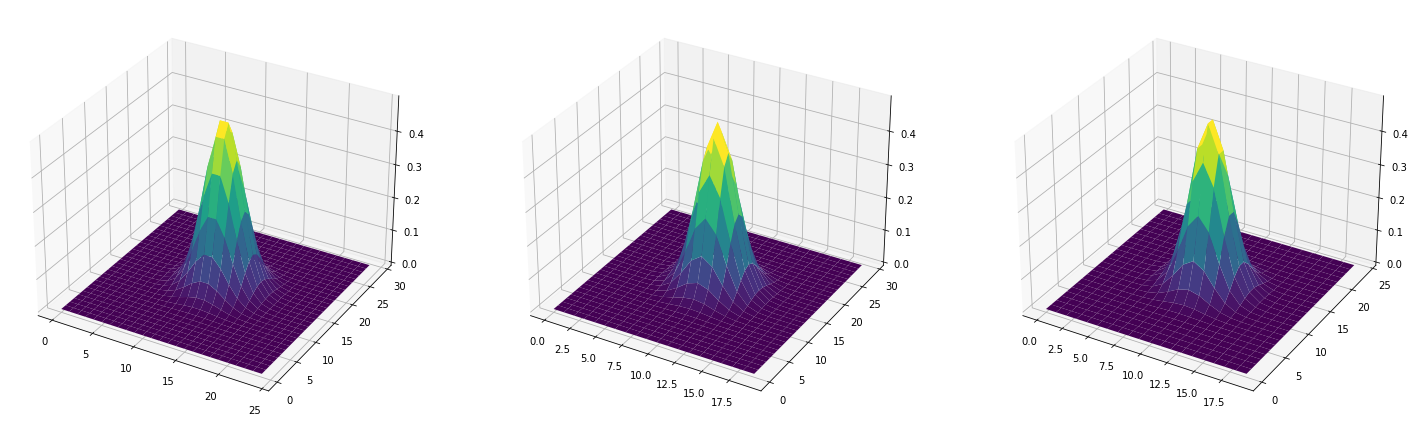

State no: 1 energy value: 5.00006754155283


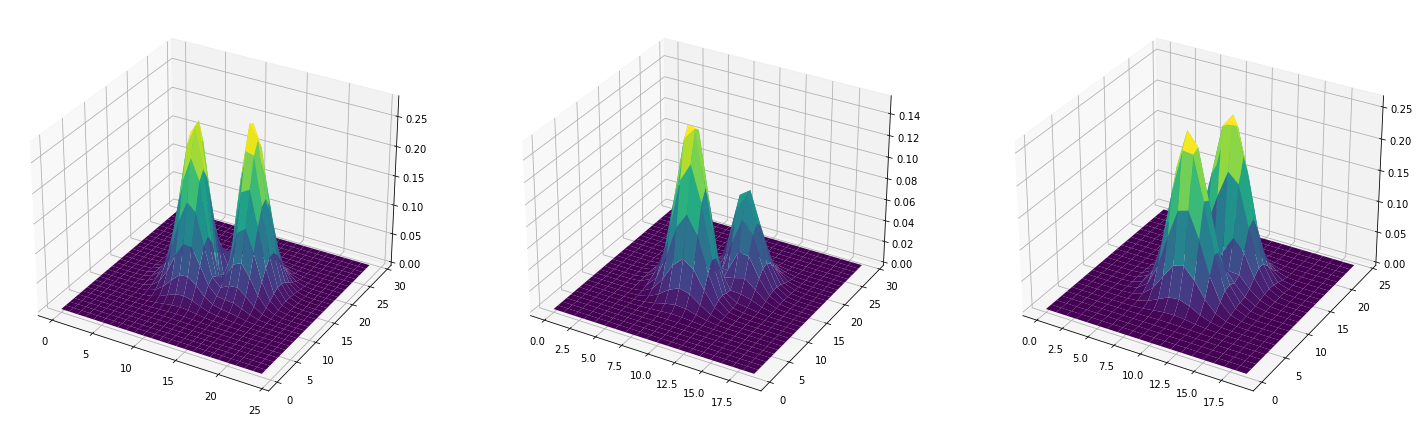

State no: 2 energy value: 5.0001944788334844


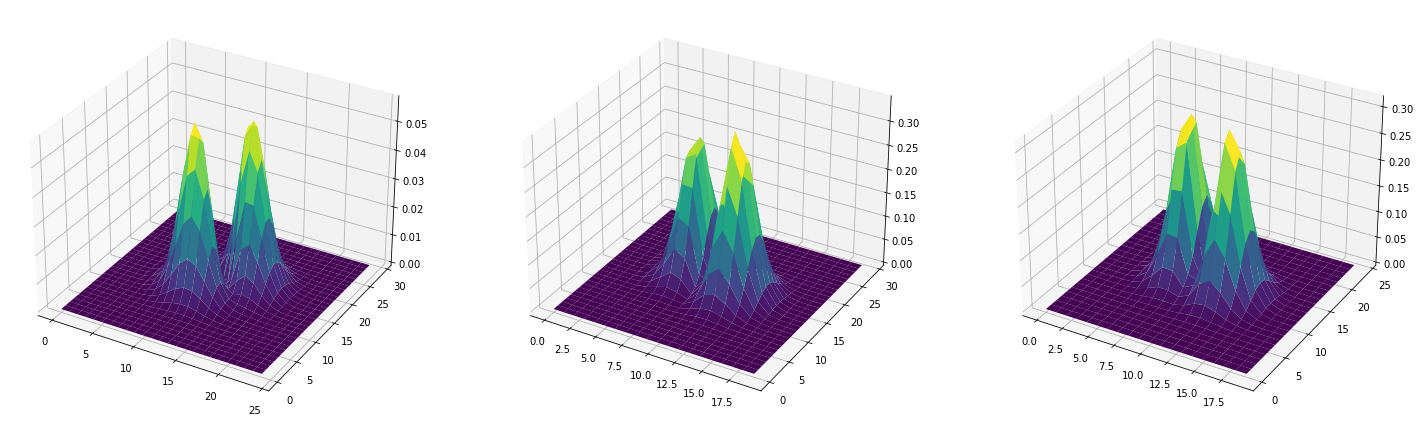

State no: 3 energy value: 5.002420402129166


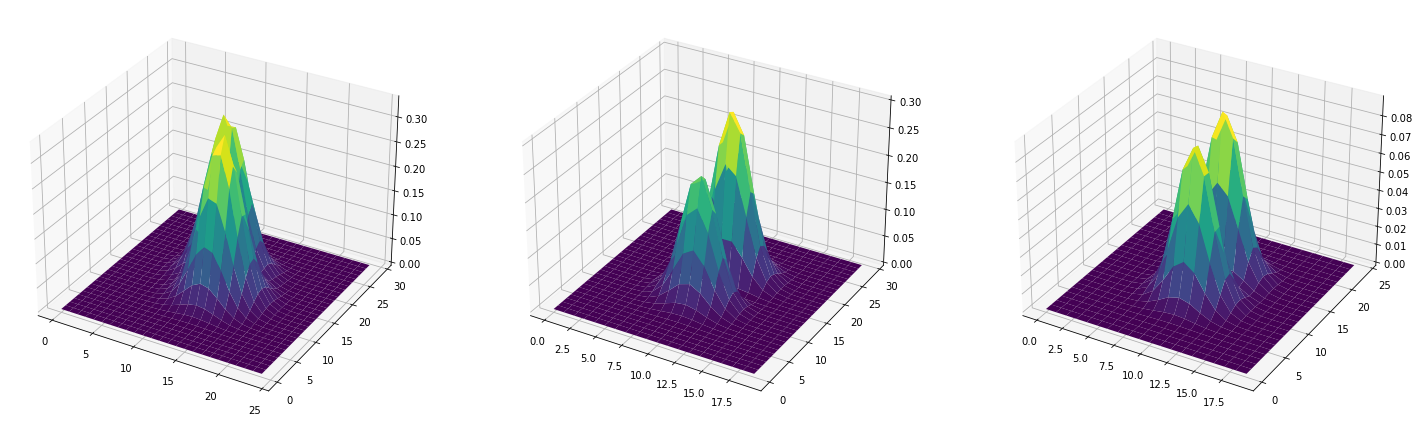

In [55]:
for i in range(4): 
    dat = cI(Psi[:,i])
    dat = np.real(dat.conjugate() * dat)
    print('State no:', i, 'energy value:', epsilon[i])
    Plot(dat)

Now, DFT

In [56]:
f = 2

In [57]:
def getgrad(W):
    U = W.transpose().conjugate() @ O(W)
    Uinv = np.linalg.inv(U)
    HW = H(W)  
    return f * (HW - (O(W) @ Uinv) @ (W.transpose().conjugate() @ HW)) @ Uinv

In [58]:
def PoissonSolve(inp):
    if inp.ndim == 1:
        n = np.reshape(inp, (inp.size, 1))
    else:
        n = inp
        
    return -4. * m.pi * Linv(O(cJ(n)))

In [59]:
def excVWN(n):
    X1 = 0.75*(3.0/(2.0*m.pi))**(2.0/3.0)
    A  =  0.0310907
    x0 = -0.10498
    b  = 3.72744
    c  = 12.9352
    Q  = m.sqrt(4*c-b*b)
    X0 = x0*x0+b*x0+c

    rs=(4*m.pi/3*n)**(-1./3.)
  
    x = np.sqrt(rs)
    X = x*x+b*x+c

    return -X1/rs + A*(np.log(x * x / X) +2 * b / Q * np.arctan(Q/(2 * x+b)) - (b*x0)/X0*(np.log((x-x0)*(x-x0)/X)+2*(2*x0+b)/Q*np.arctan(Q/(2*x+b))))

In [60]:
def getE(W):
    U = W.transpose().conjugate() @ O(W)
    Uinv = np.linalg.inv(U)
    IW = cI(W)
    
    n = f * diagouter(IW @ Uinv, IW)
    ndag = n.transpose().conjugate()
    
    Phi = PoissonSolve(n)
    exc = excVWN(n)
    
    E = np.real(-f * 0.5 * np.sum(diagouter(L(W @ Uinv), W)) + Vdual.transpose().conjugate() @ n + 0.5 * ndag @ cJdag(O(Phi)) + ndag @ cJdag(O(cJ(exc))))
    return E

In [61]:
def excpVWN(n):
    X1 = 0.75*(3.0/(2.0*m.pi))**(2.0/3.0)
    A  =  0.0310907
    x0 = -0.10498
    b  = 3.72744
    c  = 12.9352
    Q  = m.sqrt(4.*c-b*b)
    X0 = x0*x0+b*x0+c

    rs=(4.*m.pi/3. * n)**(-1./3.)

    x=np.sqrt(rs)
    X=x*x+b*x+c

    dx=0.5/x

    return (-rs/(3.*n))* dx * (2.*X1/(rs*x)+A*(2./x-(2.*x+b)/X-4.*b/(Q*Q+(2.*x+b)*(2.*x+b))-(b*x0)/X0*(2./(x-x0)-(2.*x+b)/X-4.*(2.*x0+b)/(Q*Q+(2*x+b)*(2*x+b)))))

In [62]:
def H(W):
    U = W.transpose().conjugate() @ O(W)
    Uinv = np.linalg.inv(U)
    IW = cI(W)

    n = f * diagouter(IW @ Uinv, IW)
    
    Phi = PoissonSolve(n)
  
    exc = excVWN(n)
    excp = excpVWN(n)

    Veff = Vdual + cJdag(O(Phi)) + cJdag(O(cJ(exc))) + np.reshape(excp, (excp.size,1)) * cJdag(O(cJ(n)))
    
    return -0.5 * L(W) + cIdag(Diagprod(Veff, IW))

In [63]:
np.random.seed(100)

W = np.random.randn(np.prod(S),Ns) + 1j * np.random.randn(np.prod(S),Ns)
W = orthogonalize(W)

In [64]:
W = sd(W,600)

In [65]:
Psi, epsilon = getPsi(W)

In [66]:
epsilon

array([5.50925816, 6.94934695, 6.94936642, 6.94956256])

In [67]:
print('Total energy:', getE(W)[0])

Total energy: 43.337604487274234


State no: 0 energy value: 5.509258156534148


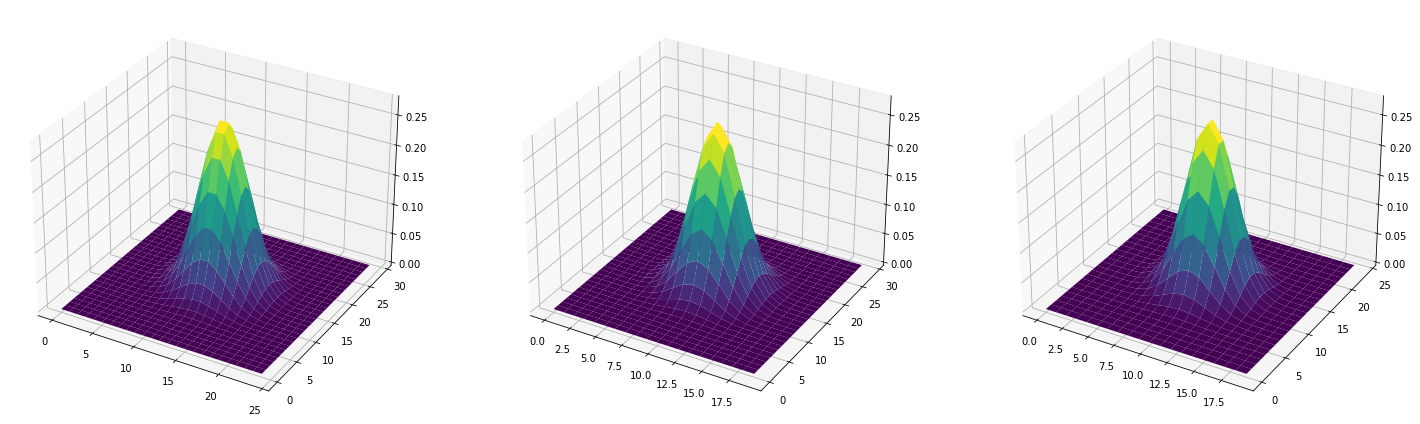

State no: 1 energy value: 6.949346950419331


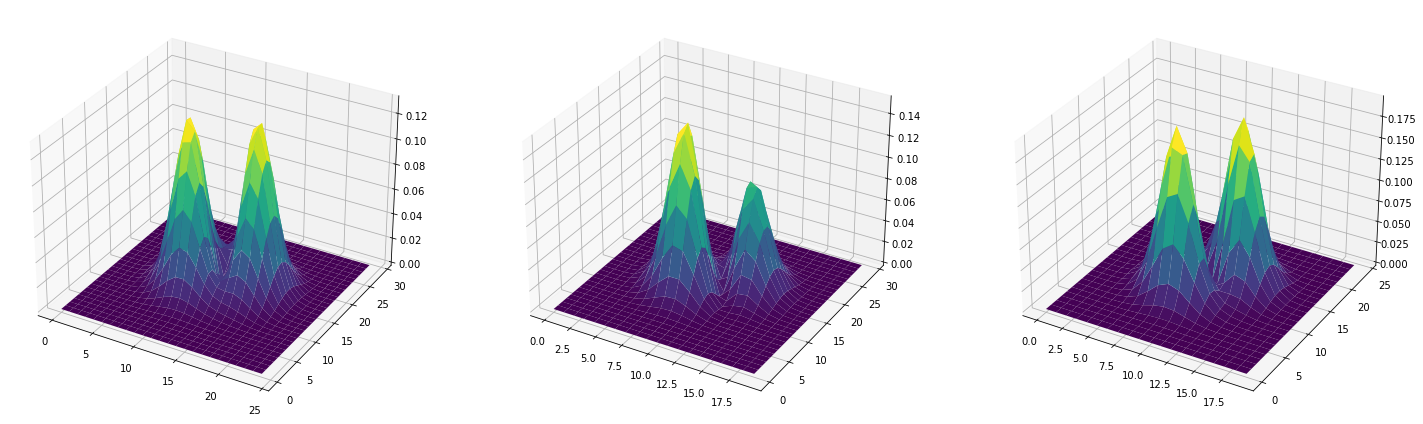

State no: 2 energy value: 6.94936642397238


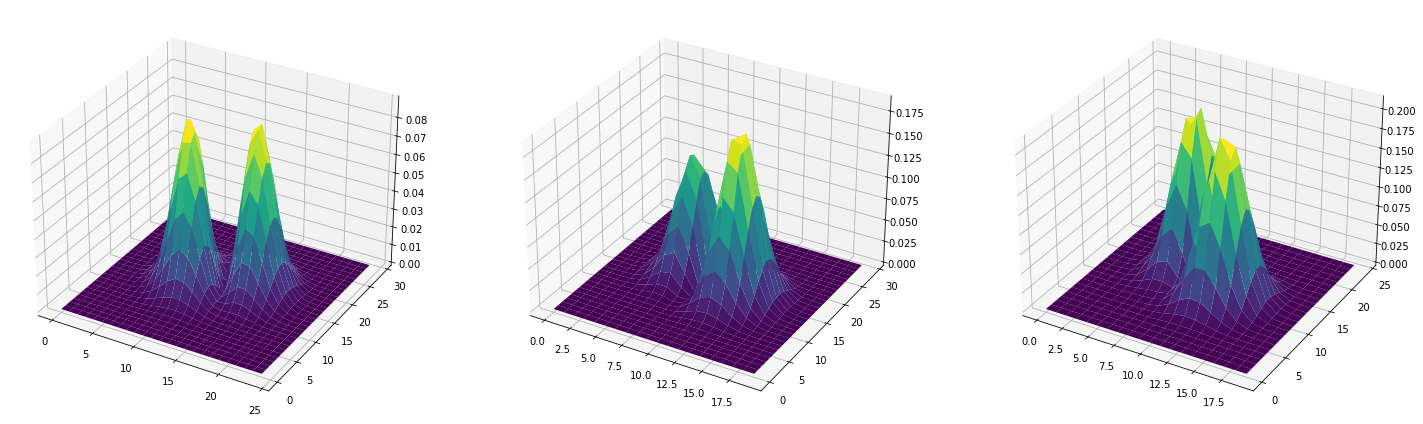

State no: 3 energy value: 6.949562559083644


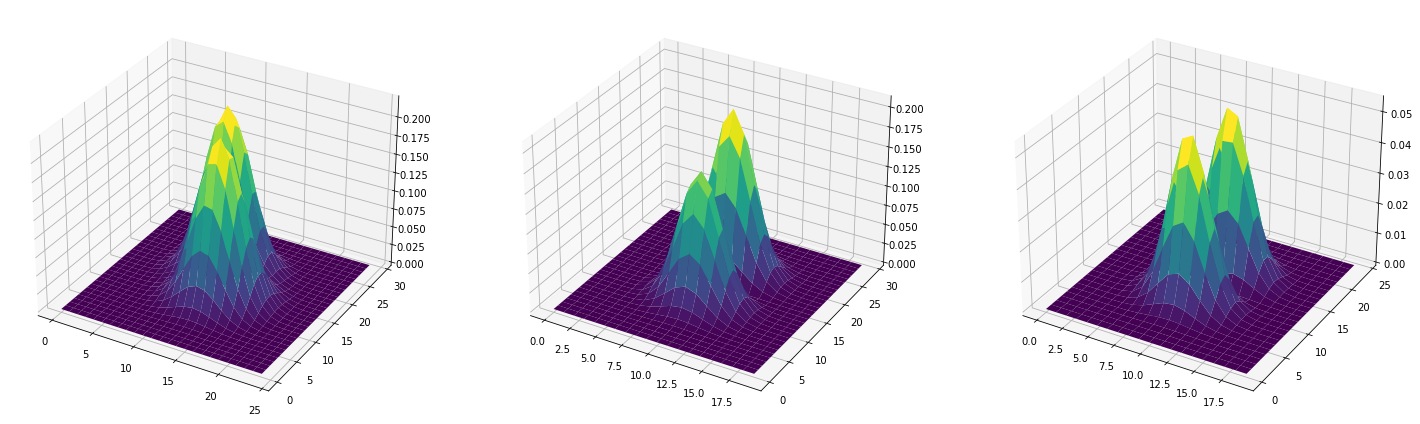

In [68]:
for i in range(4): 
    dat = cI(Psi[:,i])
    dat = np.real(dat.conjugate() * dat)
    print('State no:', i, 'energy value:', epsilon[i])
    Plot(dat)